## Data Workflow 

#### Data Collection -----
<ol>
    All surface-tethered DNA molecules tracked are used for Data Processing, except:
        <ul>
            <li>Those with multiple DNA molecules (tested as described in literature)</li>
            <li>Those that are lost due to DNA breakage during the experiment. </li>
            <li>Those that are not fully extended from the begining of the assay.</li>
            <li>Those that get adhered to the surface or to nearby beads (delta_z smaller than -0.5 um) for more than half of the duration of the assay.</li>
        </ul><br>
    For each tracking area (30-40 molecules):
        <ol>
            <li>Exclude the "bad" molecules following the criteria listed above. 
            <li>Get the baseline extension values (maximum extension, assay's step 1) for all tethered molecules.</li>
            <li>For each data point of a molecule's dataset substract its baseline extension value</li>
            <li>Plot each time-course for visual evaluation </li>
            <li>Classify the data points of the assay into high-force steps and low-force steps (from assay's step 2 to step 81)</li>
            <li>Merge new dataset with the previous datasets. Final pickle-file contains all the data points from different beads, areas, and dates for a particular protein/RNA combination.
                <ol>
                    <li>If pickle-file exists, import it. If not, create it.</li>
                    <li>Add data to dictionary.</li>
                    <li>Export updated pickle-file.</li>
                </ol>All pickle-files produced in this work are available in the Data-Repository.
            </li>  
        </ol>
</ol>

#### Data Processing -----
<ol>
    <ol>
        <li>Import the data from pickle-files for the conditions of choice
        <li>Process the data:
            <ul>
                <li>For each high-force step and molecule, extract: the dwell time, the initial extension and the final extension</li>        
                <li>Merge the extension data points for all beads and compute the probability density</li>
                <li>Fit the synaptic and extended peaks to a Gaussian function.</li>
            </ul>
        </li>
        <li>Plot the extension distributions and the times distributions</li>
    </ol>
</ol>





#### Data Processing Example -----

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import mod 
import os
cm = mod.figparams.def_fig_parameters()

Figure parameters adjusted.
Figure parameters adjusted.


##### Import the data in the pickle-files inside a folder:

In [2]:
folder = 'fig3'  # the name of the folder in which the pickles are stored
# --- 
pickle_path = os.path.join(folder)
dataset = mod.manage_data.manage_data_from_pickles(folder_path=pickle_path)
conditions = dataset.keys()

Imported: 71G+Ku+X4L4+APLF+XLF, 71G+Ku+X4L4+APLF, 71G+Ku+X4L4+XLF, 71G+X4L4+APLF+XLF, done.


##### Compute values of interest (taus, deltas, #molecules):

In [3]:
threshold_um = 0.05
roll_window = 10
factor = 3    # points_for_means = factor*roll_window
# ---
values_of_interest = mod.extract_values.extracting_values_of_interest(dataset, threshold_um, roll_window, factor)

Working on condition 1/4 - 71G+Ku+X4L4+APLF+XLF... done.
Working on condition 2/4 - 71G+Ku+X4L4+APLF... done.
Working on condition 3/4 - 71G+Ku+X4L4+XLF... done.
Working on condition 4/4 - 71G+X4L4+APLF+XLF... done.
Finished!


##### Plot the Z distributions and Tau distributions

In [4]:
# FIGURE 3
fig_name = 'Fig3'
figsize = (18*cm,13*cm)
data_to_plot = [['71G+Ku+X4L4+APLF+XLF', 'Ku + X4-LIG4 + APLF + XLF'],  # dict label, legend
                ['71G+Ku+X4L4+XLF', 'Ku + X4-LIG4 + XLF'],
                ['71G+Ku+X4L4+APLF', 'Ku + X4-LIG4 + APLF'],
                ['71G+X4L4+APLF+XLF', 'X4-LIG4 + APLF + XLF']]

Cond -> Ku + X4-LIG4 + APLF + XLF
a: 25.572, mu: -0.001, sigma: 0.012, area %: 77
a: 1.073, mu: -0.175, sigma: 0.04, area %: 10
Cond -> Ku + X4-LIG4 + XLF
a: 23.57, mu: -0.001, sigma: 0.013, area %: 76
Unable to fit.
Cond -> Ku + X4-LIG4 + APLF
a: 26.134, mu: -0.001, sigma: 0.012, area %: 80
a: 1.292, mu: -0.179, sigma: 0.04, area %: 12
Cond -> X4-LIG4 + APLF + XLF
a: 33.934, mu: -0.001, sigma: 0.012, area %: 98
Not a peak, too small


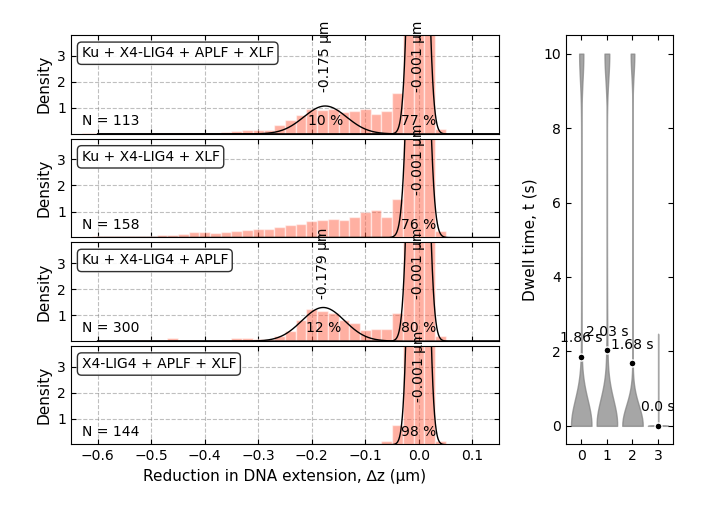

In [5]:
sigma0 = 0.02
min = 0
max = 0.04
beta = 0.025     # +- value from expected peak position
# ----
fig, axs = plt.subplots(figsize=figsize, nrows=len(data_to_plot), ncols=2, sharex='col', sharey='col', 
                        gridspec_kw={'width_ratios':[4,1], 'height_ratios':np.full((len(data_to_plot)), 5), 
                        'wspace':0.25, 'hspace':0.05, 'left':0.1, 'right':0.95, 'bottom':0.13, 'top':0.93})
# ----- 1st column 
xmin, xmax, ymin, ymax = -0.65, 0.15, 0.01, 3.8  # set limits
axs[-1,0].set(ylim=(ymin, ymax), xlim=(xmin, xmax), xlabel='Reduction in DNA extension, ∆z (µm)')

for i, line in enumerate(data_to_plot):
    print(f'Cond -> {line[1]}')
    mod.plotting_distributions.plot_distribution(axs[i,0], line, dataset, bw=0.02, sigmas=(sigma0, min, max), beta=beta)

# ----- 2nd column 
gs = axs[0, 1].get_gridspec()
for ax in axs[0:, -1]: ax.remove() # remove the underlying axes
axbig = fig.add_subplot(gs[0:, -1]) # create big one
mod.plotting_distributions.plot_times(axbig, data_to_plot, values_of_interest)

Save the figure.

In [ ]:
path = os.path.join(pickle_path, fig_name)
plt.savefig(path+'.pdf', transparent=True)

##### Visualize the timecourses:

In [6]:
pickledata = mod.manage_pickles.import_data_from_pickle(pickle_path)
# ---
data_all = {}
for cond in pickledata.keys():
    i = 0
    data_all[cond]={}
    for exp in pickledata[cond]:
        d = pickledata[cond][exp]['aligned']
        labels =  [element for element in d.keys() if 'Z' in element and 'Bead' in element]
        for bead in labels:
            data_all[cond][f'Bead#{i}'] = d[bead]
            i += 1
mag_position = pickledata[cond][exp]['aligned']['Shift pos (mm)']
time = pickledata[cond][exp]['aligned']['Time (sg)']
force = 10**(0.7344-0.31104*mag_position)
def plot(cond):
    fig, axs = plt.subplots(nrows=2, figsize=(18*cm,13*cm), sharex=True, sharey=False, 
                        gridspec_kw={'width_ratios':[5], 'height_ratios':[5, 1]})
                        #'top':0.91, 'bottom':0.13, 'hspace':0.05, 'wspace':0.03, 'left':0.15, 'right':0.99})
    plt.ion()
    # ---
    total = len(data_all[cond])
    # ---
    def update_bead(number):
        axs[0].clear(); axs[1].clear(); 
        # ---
        x, y = time, data_all[cond][f'Bead#{number}']
        axs[0].scatter(x, y, c='firebrick', s=0.5, marker='.', alpha=1, label = f'{cond}')
        axs[0].set(ylabel='∆z (µm)', xlim=(time.min(), time.max()), ylim=(-1.40, 0.2))
        axs[0].axhline((0), 0, 1, ls = ':', color='black', ms = 1)
        axs[0].axhline((-0.2), 0, 1, ls = ':', color='black', ms = 1)
        # ---
        x, y = time, force
        axs[1].plot(x, y, color='black', lw=1)  
        axs[1].set(xlim=(time.min(), time.max()), ylim=(-0.2,2.4), xlabel='Time (s)', ylabel='F (pN)')
    widgets.interact(update_bead, number=widgets.BoundedIntText(min=0, max=total, step=1, description='Bead:'))
data_all.keys()

dict_keys(['71G+Ku+X4L4+APLF+XLF', '71G+Ku+X4L4+APLF', '71G+Ku+X4L4+XLF', '71G+X4L4+APLF+XLF'])

interactive(children=(BoundedIntText(value=0, description='Bead:', max=300), Output()), _dom_classes=('widget-…

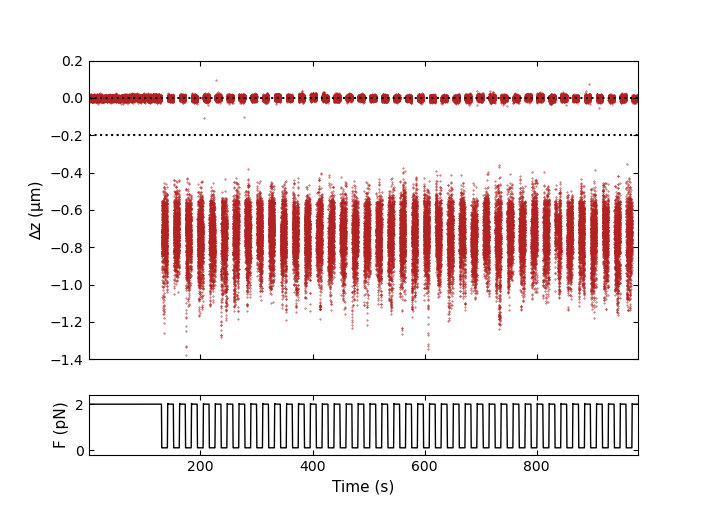

In [7]:
cond = '71G+Ku+X4L4+APLF'
plot(cond)